Orden BP original: 2 (orden total: 4)
wn BP (rad/s): [5026.54824574 7853.98163397]

--- H_bp(s) = numerador / denominador ---
Numerador (coeficientes descendentes, s^{len(b_bp)-1} a s^0): [16420899.35        0.          0.  ]
Denominador: [1.00000000e+00 5.08000000e+03 9.58572335e+07 2.00550427e+11
 1.55854546e+15]
Ejemplo: H_bp(s) = (1.64e+07 s^2) / (s^4 + 5.08e+03 s^3 + 9.59e+07 s^2 + 2.01e+11 s + 1.56e+15)

Sección 1:
H_PasaAlto(s) =
       +5.0000e-01 s²  +  +0.0000e+00 s  +  +0.0000e+00
     ────────────────────────────────────────────────
       +1.0000e+00 s²  +  +1.8956e+03 s  +  +2.3500e+07


Sección 2:
H_PasaBajo(s) =
       +3.2842e+07
     ────────────────────────────────────────────────
       +1.0000e+00 s²  +  +3.1844e+03 s  +  +6.6321e+07

Filtro bandpass completo H(s) = H₁(s) × H₂(s)
Numerador:
   +1.6421e+07 s² +  +0.0000e+00 s +  +0.0000e+00
Denominador:
   +1.0000e+00 s⁴ +  +5.0800e+03 s³ +  +9.5857e+07 s² +  +2.0055e+11 s +  +1.5585e+15


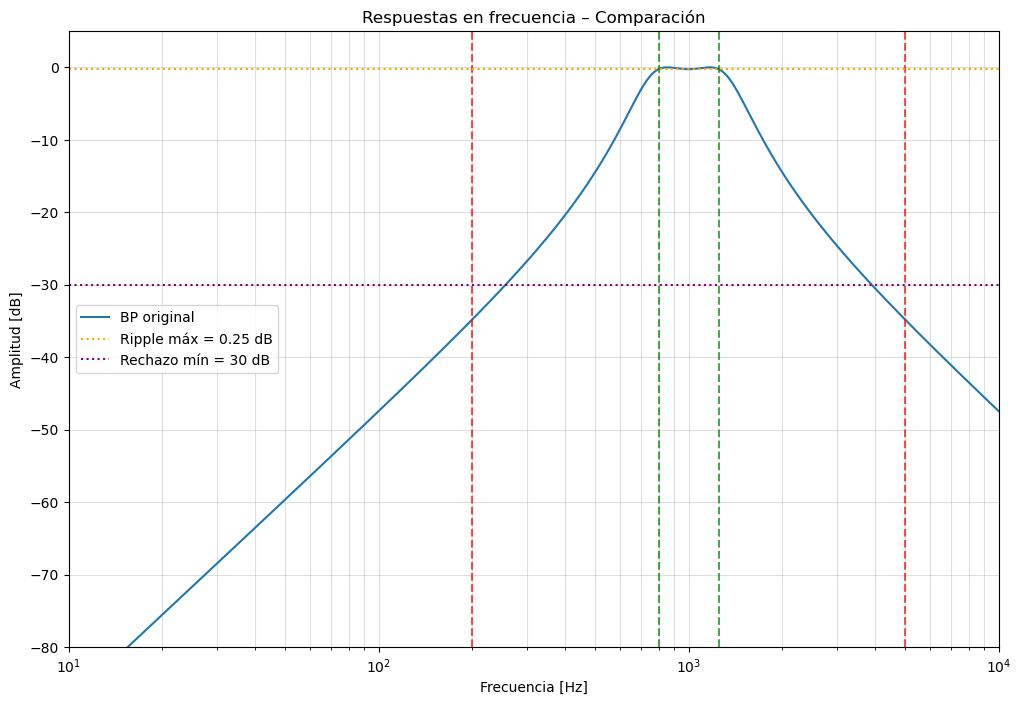

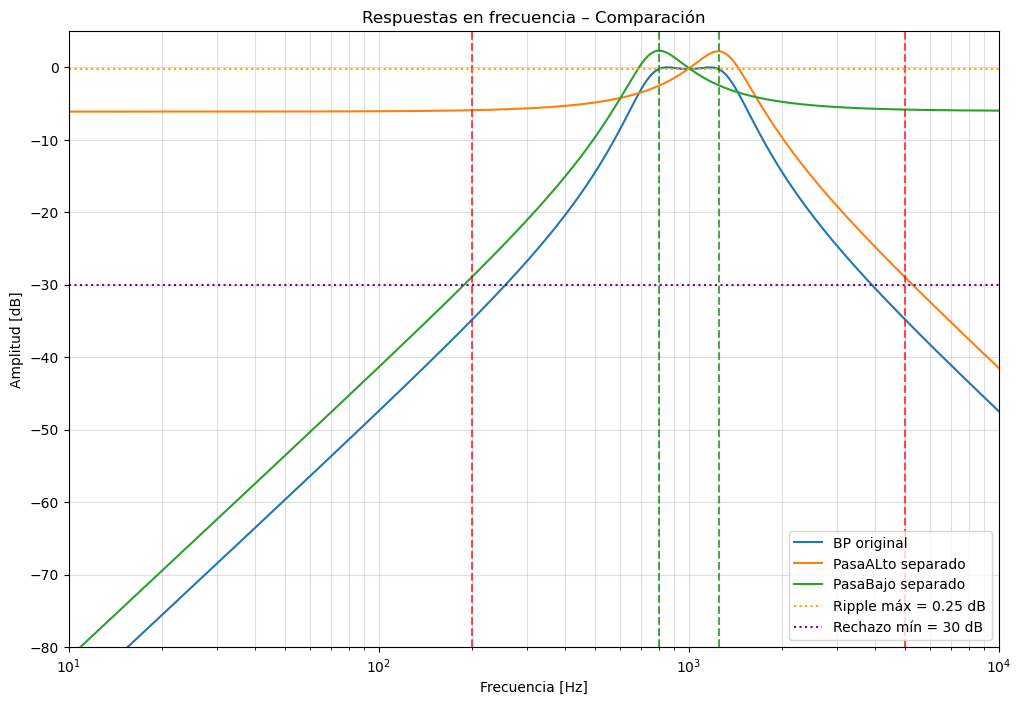

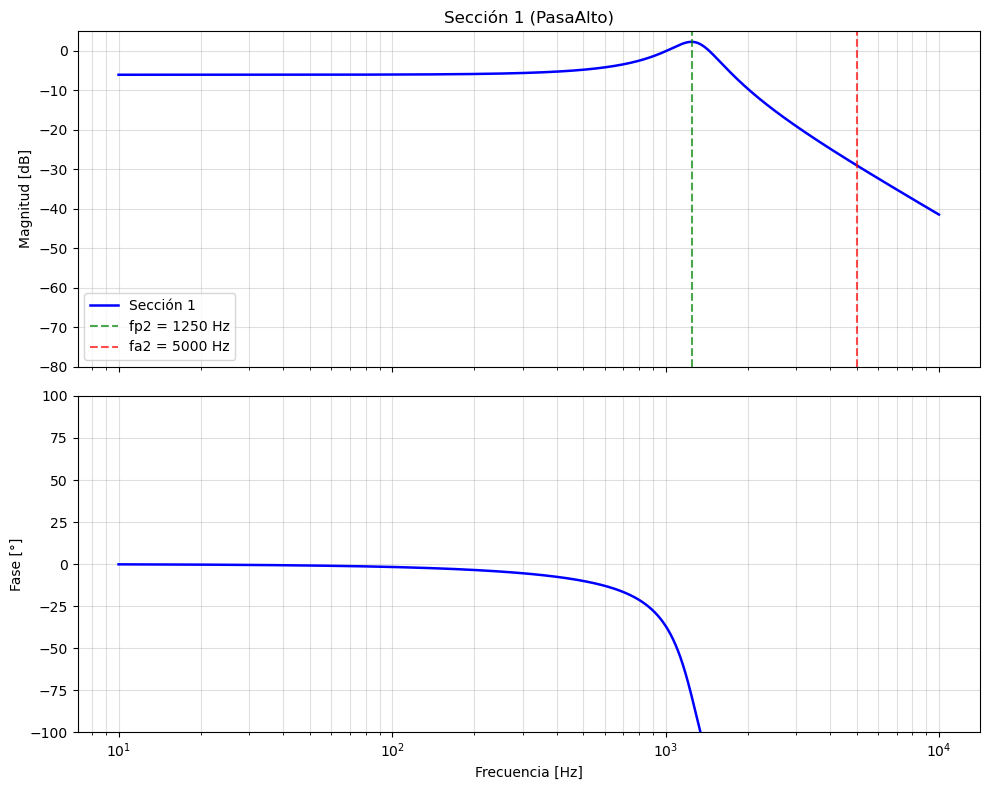

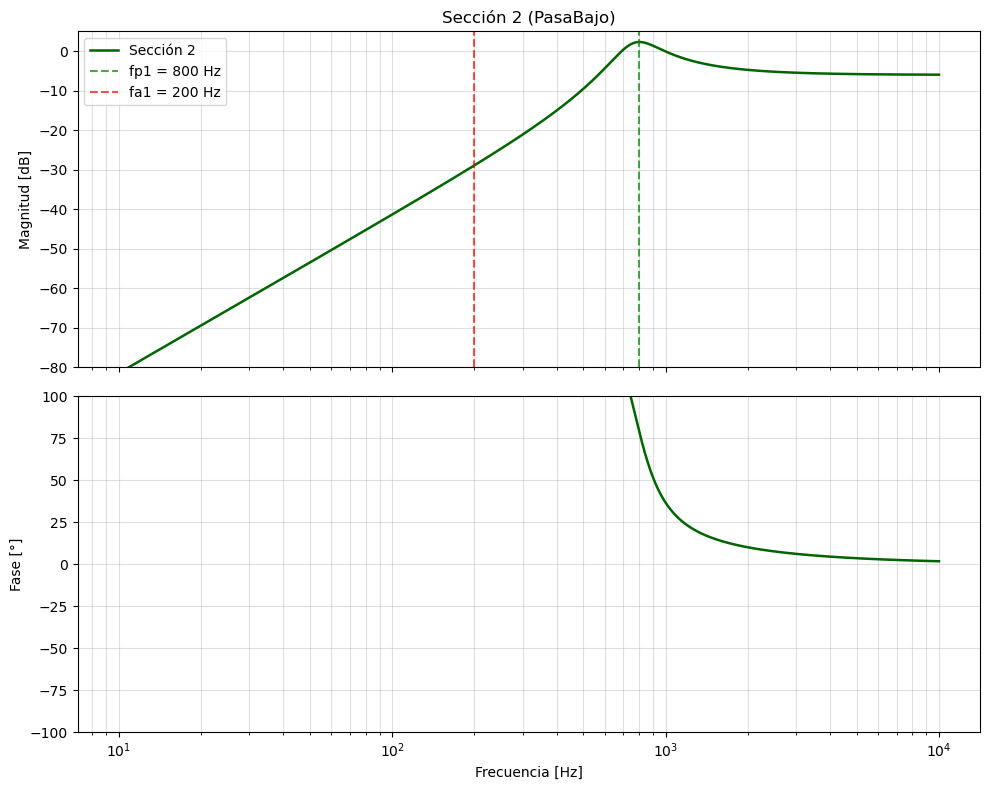

In [8]:
import numpy as np
import scipy.signal as signal
from scipy.signal import cheb1ord, cheby1, freqs
import matplotlib.pyplot as plt

# Especificaciones (en Hz)
fp1 = 800    # Hz borde inferior banda de paso
fp2 = 1250   # Hz borde superior banda de paso
fa1 = 200    # Hz borde superior rechazo inferior
fa2 = 5000   # Hz borde inferior rechazo superior

Rp = 0.25    # dB ripple en banda de paso
Rs = 30      # dB atenuación mínima en bandas de rechazo

# Convertir a frecuencias angulares (rad/s)
wp_bp = 2 * np.pi * np.array([fp1, fp2])
ws_bp = 2 * np.pi * np.array([fa1, fa2])

#wp_hp = 2 * np.pi * fp1
#ws_hp = 2 * np.pi * fa1

#wp_lp = 2 * np.pi * fp2
#ws_lp = 2 * np.pi * fa2

# 1. Diseñar el filtro pasa-banda
order_bp, wn_bp = cheb1ord(wp_bp, ws_bp, Rp, Rs, analog=True)
b_bp, a_bp = cheby1(order_bp, Rp, wn_bp, btype='bandpass', analog=True)

print(f"Orden BP original: {order_bp} (orden total: {len(a_bp)-1})")
print(f"wn BP (rad/s): {wn_bp}")

print("\n--- H_bp(s) = numerador / denominador ---")
print("Numerador (coeficientes descendentes, s^{len(b_bp)-1} a s^0):", np.round(b_bp, decimals=2))
print("Denominador:", np.round(a_bp, decimals=2))
print("Ejemplo: H_bp(s) = (%.2e s^2) / (s^4 + %.2e s^3 + %.2e s^2 + %.2e s + %.2e)" % (b_bp[0], a_bp[1], a_bp[2], a_bp[3], a_bp[4]))


#Sintetizamos en dos filtros con funciones bicuadraticas
sos=signal.cheby1(order_bp, Rp, wn_bp, btype='bandpass',output='sos', analog=True )
PasaBajo=signal.TransferFunction(2*sos[0,:3], sos[0,3:])
PasaAlto=signal.TransferFunction(1/2*sos[1,:3], sos[1,3:])

#PasaAlto
print("\nSección 1:")
print("H_PasaAlto(s) =")
print(f"       {PasaAlto.num[0]:+.4e} s²  +  {PasaAlto.num[1]:+.4e} s  +  {PasaAlto.num[2]:+.4e}")
print("     ────────────────────────────────────────────────")
print(f"       {PasaAlto.den[0]:+.4e} s²  +  {PasaAlto.den[1]:+.4e} s  +  {PasaAlto.den[2]:+.4e}")
print("")

#PasaBajo
print("\nSección 2:")
print("H_PasaBajo(s) =")
print(f"       {PasaBajo.num[0]:+.4e}")
print("     ────────────────────────────────────────────────")
print(f"       {PasaBajo.den[0]:+.4e} s²  +  {PasaBajo.den[1]:+.4e} s  +  {PasaBajo.den[2]:+.4e}")
print("")

#Convolucion de los filtros para verificacion
num_total = np.convolve(PasaAlto.num, PasaBajo.num)
den_total = np.convolve(PasaAlto.den, PasaBajo.den)

print("Filtro bandpass completo H(s) = H₁(s) × H₂(s)")
print("Numerador:")
print(f"   {num_total[0]:+.4e} s² +  {num_total[1]:+.4e} s +  {num_total[2]:+.4e}")
print("Denominador:")
print(f"   {den_total[0]:+.4e} s⁴ +  {den_total[1]:+.4e} s³ +  {den_total[2]:+.4e} s² +  {den_total[3]:+.4e} s +  {den_total[4]:+.4e}")


# Extraer secciones
b1 = 2*sos[0, :3]   # Sección 1 (numerador ~ s²)
a1 = sos[0, 3:]
b2 = 1/2*sos[1, :3]   # Sección 2 (numerador constante)
a2 = sos[1, 3:]


# 5. Graficar respuestas en frecuencia
w = np.logspace(np.log10(2*np.pi*10), np.log10(2*np.pi*10000), 2000)  # rad/s, ~10 Hz a 10 kHz

# BP original
h_bp = freqs(b_bp, a_bp, worN=w)[1]
mag_bp = 20 * np.log10(np.abs(h_bp))

# Respuesta en frecuencia de cada sección
_, h1 = signal.freqs(b1, a1, worN=w)
_, h2 = signal.freqs(b2, a2, worN=w)

mag1_db = 20 * np.log10(np.abs(h1))
phase1_deg = np.angle(h1, deg=True)

mag2_db = 20 * np.log10(np.abs(h2))
phase2_deg = np.angle(h2, deg=True)

frec_hz = w / (2 * np.pi)   # para eje x en Hz


plt.figure(figsize=(12, 8))
plt.semilogx(w / (2*np.pi), mag_bp, label='BP original')
plt.title('Respuestas en frecuencia – Comparación')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both', alpha=0.4)
plt.axvline(fp1, color='green', ls='--', alpha=0.7)
plt.axvline(fp2, color='green', ls='--', alpha=0.7)
plt.axvline(fa1, color='red', ls='--', alpha=0.7)
plt.axvline(fa2, color='red', ls='--', alpha=0.7)
plt.axhline(-Rp, color='orange', ls=':', label=f'Ripple máx = {Rp} dB')
plt.axhline(-Rs, color='purple', ls=':', label=f'Rechazo mín = {Rs} dB')
plt.legend()
plt.xlim(10, 10000)
plt.ylim(-80, 5)
plt.show()



plt.figure(figsize=(12, 8))
plt.semilogx(w / (2*np.pi), mag_bp, label='BP original')
plt.semilogx(w / (2*np.pi), mag1_db, label='PasaALto separado')
plt.semilogx(w / (2*np.pi), mag2_db, label='PasaBajo separado')
plt.title('Respuestas en frecuencia – Comparación')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both', alpha=0.4)
plt.axvline(fp1, color='green', ls='--', alpha=0.7)
plt.axvline(fp2, color='green', ls='--', alpha=0.7)
plt.axvline(fa1, color='red', ls='--', alpha=0.7)
plt.axvline(fa2, color='red', ls='--', alpha=0.7)
plt.axhline(-Rp, color='orange', ls=':', label=f'Ripple máx = {Rp} dB')
plt.axhline(-Rs, color='purple', ls=':', label=f'Rechazo mín = {Rs} dB')
plt.legend()
plt.xlim(10, 10000)
plt.ylim(-80, 5)
plt.show()


# Rango de frecuencias (rad/s) → de ~1 Hz a ~20 kHz
#w = np.logspace(np.log10(2*np.pi*1), np.log10(2*np.pi*20000), 5000)



# ─── Gráfica 1: Sección 1 (parecida a pasa-altos) ─────────────────────
fig1, (ax_mag1, ax_phase1) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax_mag1.semilogx(frec_hz, mag1_db, 'b', lw=1.8, label='Sección 1')
ax_mag1.set_title('Sección 1 (PasaAlto)')
ax_mag1.set_ylabel('Magnitud [dB]')
ax_mag1.grid(True, which='both', alpha=0.4)
ax_mag1.axvline(fp2, color='g', ls='--', alpha=0.7, label=f'fp2 = {fp2} Hz')
ax_mag1.axvline(fa2, color='r', ls='--', alpha=0.7, label=f'fa2 = {fa2} Hz')
ax_mag1.legend()
ax_mag1.set_ylim(-80, 5)

ax_phase1.semilogx(frec_hz, phase1_deg, 'b', lw=1.8)
ax_phase1.set_ylabel('Fase [°]')
ax_phase1.set_xlabel('Frecuencia [Hz]')
ax_phase1.grid(True, which='both', alpha=0.4)
ax_phase1.set_ylim(-100, 100)

plt.tight_layout()
plt.show()

# ─── Gráfica 2: Sección 2 (parecida a pasa-bajos) ─────────────────────
fig2, (ax_mag2, ax_phase2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax_mag2.semilogx(frec_hz, mag2_db, 'darkgreen', lw=1.8, label='Sección 2')
ax_mag2.set_title('Sección 2 (PasaBajo)')
ax_mag2.set_ylabel('Magnitud [dB]')
ax_mag2.grid(True, which='both', alpha=0.4)
ax_mag2.axvline(fp1, color='g', ls='--', alpha=0.7, label=f'fp1 = {fp1} Hz')
ax_mag2.axvline(fa1, color='r', ls='--', alpha=0.7, label=f'fa1 = {fa1} Hz')
ax_mag2.legend()
ax_mag2.set_ylim(-80, 5)

ax_phase2.semilogx(frec_hz, phase2_deg, 'darkgreen', lw=1.8)
ax_phase2.set_ylabel('Fase [°]')
ax_phase2.set_xlabel('Frecuencia [Hz]')
ax_phase2.grid(True, which='both', alpha=0.4)
ax_phase2.set_ylim(-100, 100)

plt.tight_layout()
plt.show()
